In [1]:
import CountingNN
import numpy as np



In [2]:
import re
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from CountingNN.evaluation import * #See CountingNN/evaluation.py ## NOTE: Add to init
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
import matplotlib.pyplot as plt
import h5py
import wandb
import random


# Configure Keras to use GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)



2024-04-16 12:19:32.577466: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-16 12:19:32.610508: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 12:19:32.610536: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 12:19:32.611425: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-16 12:19:32.617463: I tensorflow/core/platform/cpu_feature_guar

In [3]:
with h5py.File('TrainingData5zeroes.h5', 'r') as hdf:
    ls = list(hdf.keys())
    images = hdf.get('images')
    boxes = hdf.get('boxes')
    images = np.array(images)
    boxes = np.array(boxes)


image_normalized = (images + 1e-9) / 9.26
normalized_boxes = boxes / [1, 64, 64, 64, 64]

images_np = image_normalized

probabilities = np.array(normalized_boxes[:, :, :-4])
probabilities = tf.expand_dims(probabilities, axis=1)
boxes_np = np.array(normalized_boxes[:, :, 1:])
boxes_np = tf.expand_dims(boxes_np, axis=1)
batch_size = 128
dataset = tf.data.Dataset.from_tensor_slices((images_np, {'x_prob_reshape': probabilities, 'x_boxes_reshape': boxes_np}))
dataset = dataset.shuffle(buffer_size=10000).batch(batch_size)


2024-04-16 12:14:27.764143: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21584 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


In [4]:
input_shape = (64,64,1)
num_classes = 280
num_coordinates = 4

x_input = layers.Input(shape=input_shape)
#Layer 1
x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x_input)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) 
x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
#Layer 2
x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
#Layer 3
x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
#Layer 4
x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
#Layer 5
x = layers.Conv2D(256, kernel_size=5, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) 


x = layers.Flatten()(x)
# Probability output
x_prob = layers.Dense(num_classes, activation='sigmoid', name='x_prob')(x)
x_prob_reshape = layers.Reshape((-1, num_classes, 1), name='x_prob_reshape')(x_prob)

# Bounding box output
x_boxes = layers.Dense(num_classes * num_coordinates, activation='sigmoid', name='x_boxes')(x)
x_boxes_reshape = layers.Reshape((-1, num_classes, num_coordinates), name='x_boxes_reshape')(x_boxes)


model = tf.keras.models.Model(x_input, [x_prob_reshape, x_boxes_reshape])
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5) 
model.compile(optimizer= optimizer, loss= {'x_prob_reshape': tf.keras.losses.BinaryCrossentropy(), 'x_boxes_reshape':tf.keras.losses.MeanSquaredError()}, metrics={'x_prob_reshape': 'accuracy'} )
num_epochs = 100

In [32]:
x.shape

TensorShape([None, 64, 64, 64])

In [7]:
loaded_model = tf.keras.models.load_model("/home/m3-learning/Documents/Research Data/Derrick's Object Detection/Models/M11overfittedmodel3variant.h5")

In [9]:
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 64)           640       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 64)           256       ['max_pooling2d[0][0]']   

In [4]:
# model = torch.load("/home/m3-learning/Documents/Research Data/Derrick's Object Detection/Models/M11overfittedmodel1variant.keras")
# model  = tf.keras.models.load_model("/home/m3-learning/Documents/Research Data/Derrick's Object Detection/Models/M11overfittedmodel3variant.h5")

In [5]:
# import tensorflow as tf

# def process_predictions(probabilities, boxes, threshold=0.5):
#     # Apply threshold to filter out bounding boxes based on probability
#     mask = probabilities > threshold
#     filtered_probs = tf.boolean_mask(probabilities, mask)
#     filtered_boxes = tf.boolean_mask(boxes, mask)

#     # Sort boxes and probabilities by confidence for non-max suppression
#     idxs = tf.argsort(filtered_probs, direction='DESCENDING')
#     sorted_boxes = tf.gather(filtered_boxes, idxs)
#     sorted_probs = tf.gather(filtered_probs, idxs)

#     # Apply non-max suppression
#     selected_indices = tf.image.non_max_suppression(
#         sorted_boxes, sorted_probs, max_output_size=boxes.shape[0], iou_threshold=0.5)

#     final_boxes = tf.gather(sorted_boxes, selected_indices)
#     final_probs = tf.gather(sorted_probs, selected_indices)

#     return final_probs, final_boxes

# # Assuming 'model.predict' returns a dictionary with 'x_prob_reshape' and 'x_boxes_reshape'
# predictions = model.predict(images_np)  # images_np should be your preprocessed image batch

# # Process predictions
# processed_probabilities, processed_boxes = process_predictions(
#     predictions['x_prob_reshape'], predictions['x_boxes_reshape'])


In [10]:
dataset = tf.data.Dataset.from_tensor_slices((images_np,{'x_prob_reshape':probabilities,'x_boxes_reshape':boxes_np}))
dataset = dataset.batch(10000)
inputs,targets = next(iter(dataset))
output =loaded_model.predict(inputs)


2024-04-16 12:19:04.600114: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:447] Loaded runtime CuDNN library: 8.7.0 but source was compiled with: 8.9.4.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2024-04-16 12:19:04.600633: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:625 : UNIMPLEMENTED: DNN library is not found.


UnimplementedError: Graph execution error:

Detected at node model/conv2d/Relu defined at (most recent call last):
  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/m3-learning/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/m3-learning/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1077, in launch_instance

  File "/home/m3-learning/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/m3-learning/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/m3-learning/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 529, in dispatch_queue

  File "/home/m3-learning/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 518, in process_one

  File "/home/m3-learning/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 424, in dispatch_shell

  File "/home/m3-learning/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 766, in execute_request

  File "/home/m3-learning/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/home/m3-learning/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/m3-learning/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell

  File "/home/m3-learning/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell

  File "/home/m3-learning/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/m3-learning/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async

  File "/home/m3-learning/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes

  File "/home/m3-learning/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code

  File "/tmp/ipykernel_61466/2204118894.py", line 4, in <module>

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/engine/training.py", line 2655, in predict

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/engine/training.py", line 2440, in predict_function

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/engine/training.py", line 2425, in step_function

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/engine/training.py", line 2413, in run_step

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/engine/training.py", line 2381, in predict_step

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py", line 321, in call

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/activations.py", line 306, in relu

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/backend.py", line 5395, in relu

DNN library is not found.
	 [[{{node model/conv2d/Relu}}]] [Op:__inference_predict_function_2617]

In [6]:

# file_paths = [
#     '/home/m3-learning/Documents/myML/ValidationResults/Stack001_result.npz',
#     '/home/m3-learning/Documents/myML/ValidationResults/Stack007_result.npz',
#     # Add other file paths as needed
# ]

# # Iterate over each file path
# for file_path in file_paths:
#     data = np.load(file_path)
#     print(f"Contents of {file_path}:")
#     print(list(data.keys()))

#     # Access data (example)
#     if 'array_name' in data:
#         array = data['array_name']
#         # Process your array here
#         print(array)
import torch
# model = torch.load(os.path.dirname(CountingNN.__file__) + '/modelweights/model_200kV_final.pt')
#model = torch.load(os.path.dirname(CountingNN.__file__) + '/modelweights/model_80kV_final.pt')

In [5]:
savepath = '/home/m3-learning/Documents/myMLValidationResults/'
path = '/home/m3-learning/Documents/myML/ValidationData-20231107T163458Z-001/'
# import time
# start_time = time.time()
# for file in os.listdir(path)[:50]:
#   if file[0] != 'S':
#     continue
#   general_evaluation(path + file,algorithm = 'fastrcnn_predict', repeat = 1, savepath = savepath, model = loaded_model,
#                      method = 'max',  mode = 'dynamic_window', stride = 64) #meanADU = 1007
#   print('\nWorked on ', file, 'cost', " %s seconds." % (time.time() - start_time))
#   start_time = time.time()


# import os
# import time
# import tensorflow as tf

# # Assume 'model' is your loaded TensorFlow model, possibly something like:
# # model = tf.keras.models.load_model('path_to_your_model')



start_time = time.time()
for file in os.listdir(path)[:50]:
    if not file.startswith('S'):
        continue
    
    
    general_evaluation(os.path.join(path, file), 
                          algorithm='fastrcnn_predict', 
                          repeat=1, 
                          savepath=savepath, 
                          model=model,  
                          method='max', 
                          mode='dynamic_window', 
                          stride=64)  # meanADU=1007 may need to be passed inside **kwargs if your function uses it
    
    print('\nWorked on ', file, 'cost', " %s seconds." % (time.time() - start_time))
    start_time = time.time()



In [41]:
import numpy as np

file_paths = [
    '/home/m3-learning/Documents/myML/ValidationResults/Stack001_result.npz',
    '/home/m3-learning/Documents/myML/ValidationResults/Stack007_result.npz',
    '/home/m3-learning/Documents/myML/ValidationResults/Stack015_result.npz',
    '/home/m3-learning/Documents/myML/ValidationResults/Stack019_result.npz'

]

# Iterate over each file path to load and print specific metrics
for file_path in file_paths:
    data = np.load(file_path)
    mae = data['mae']
    precision = data['precision']
    recall = data['recall']
    dce = data['dce']
    dce_corrected = data['dce_corrected']
    
    print(f"Metrics for {file_path}:")
    print(f"MAE: {np.mean(mae)}")
    print(f"Precision: {np.mean(precision)}")
    print(f"Recall: {np.mean(recall)}")
    print(f"DCE: {np.mean(dce)}")
    print(f"DCE Corrected: {np.mean(dce_corrected)}")
    print("-" * 30)


Metrics for /home/m3-learning/Documents/myML/ValidationResults/Stack001_result.npz:
MAE: 0.0029083251953125
Precision: 0.5270942733557651
Recall: 0.579563715833866
DCE: 1.1005134144805182
DCE Corrected: 1.1005134144805182
------------------------------
Metrics for /home/m3-learning/Documents/myML/ValidationResults/Stack007_result.npz:
MAE: 0.01475372314453125
Precision: 0.5111817626672449
Recall: 0.5457362680449849
DCE: 1.0679164079202939
DCE Corrected: 1.0674867623778663
------------------------------
Metrics for /home/m3-learning/Documents/myML/ValidationResults/Stack015_result.npz:
MAE: 0.0307403564453125
Precision: 0.506194977625215
Recall: 0.5001037702063418
DCE: 0.9884436409913258
DCE Corrected: 0.9884436409913258
------------------------------
Metrics for /home/m3-learning/Documents/myML/ValidationResults/Stack019_result.npz:
MAE: 0.0380645751953125
Precision: 0.5142659893905327
Recall: 0.4871540870003127
DCE: 0.9475161692101801
DCE Corrected: 0.9475161692101801
----------------

In [13]:
import numpy as np

# def load_data(file_path):
#     data = np.load(file_path)
#     return data['result'], data['mae'], data['dce'], data['recall'], data['precision'], data['deviations'], data['dce_corrected']

def load_data(file_path):
    """
    Load data from an NPZ file.
    """
    with np.load(file_path, allow_pickle=True) as data:
        result = data['result']
        mae = data['mae']
        dce = data['dce']
        recall = data['recall']
        precision = data['precision']
        deviations = data['deviations']
        dce_corrected = data['dce_corrected']
    return result, mae, dce, recall, precision, deviations, dce_corrected

# Metric Calculation Functions
def calculate_mae(filtered, ground_truth):
    return np.mean(np.abs(filtered - ground_truth))

def calculate_precision(tp, fp):
    return tp / (tp + fp) if (tp + fp) > 0 else 0

def calculate_recall(tp, fn):
    return tp / (tp + fn) if (tp + fn) > 0 else 0

def calculate_dce(detected_count, actual_count):
    return detected_count / actual_count if actual_count > 0 else 0

def calculate_corrected_dce(deviations, actual_count):
    valid_detections = len([d for d in deviations if d <= 6])  # Example threshold
    return valid_detections / actual_count if actual_count > 0 else 0

# Process data and calculate metrics
# def process_data(file_path):
#     predictions, ground_truth = load_data(file_path)
#     metrics = {'mae': [], 'precision': [], 'recall': [], 'dce': [], 'corrected_dce': []}
    
#     for i in range(predictions.shape[0]):
#         filtered = predictions[i]
#         truth = ground_truth[i]

#         tp = np.sum((filtered > 0) & (truth > 0))
#         fp = np.sum((filtered > 0) & (truth == 0))
#         fn = np.sum((filtered == 0) & (truth > 0))
#         detected_count = np.sum(filtered > 0)
#         actual_count = np.sum(truth > 0)

#         mae = calculate_mae(filtered, truth)
#         precision = calculate_precision(tp, fp)
#         recall = calculate_recall(tp, fn)
#         dce = calculate_dce(detected_count, actual_count)
#         deviations = np.random.uniform(0, 10, size=tp)  # Example deviations, replace with actual
#         corrected_dce = calculate_corrected_dce(deviations, actual_count)

#         metrics['mae'].append(mae)
#         metrics['precision'].append(precision)
#         metrics['recall'].append(recall)
#         metrics['dce'].append(dce)
#         metrics['corrected_dce'].append(corrected_dce)

#     # Calculate average metrics
#     for key in metrics:
#         metrics[key] = np.mean(metrics[key])

#     return metrics

# # Example usage
# file_path = '/home/m3-learning/Documents/myML/ValidationResults/Stack001_result.npz'
# results = process_data(file_path)
# print(results)

# def process_data(file_path):
#     # Load data
#     result, mae, dce, recall, precision, deviations, dce_corrected = load_data(file_path)

#     # Convert to numpy arrays if they are not already
#     mae = np.array(mae)
#     dce = np.array(dce)
#     recall = np.array(recall)
#     precision = np.array(precision)
#     dce_corrected = np.array(dce_corrected)

#     # Calculate average metrics
#     metrics = {
#         'Average MAE': np.mean(mae),
#         'Average DCE': np.mean(dce),
#         'Average Recall': np.mean(recall),
#         'Average Precision': np.mean(precision),
#         'Average Corrected DCE': np.mean(dce_corrected)
#     }

#     return metrics

# Example usage
# file_path = '/home/m3-learning/Documents/myML/ValidationResults/Stack001_result.npz'
# results = process_data(file_path)
# print("Aggregated Metrics:", results)

def process_data(file_path):
    """
    Process the loaded data to calculate average metrics.
    """
    # Load results and metrics from the file
    result, mae, dce, recall, precision, deviations, dce_corrected = load_data(file_path)

    # Calculate average of each metric
    metrics = {
        'Average MAE': np.mean(mae),
        'Average DCE': np.mean(dce),
        'Average Recall': np.mean(recall),
        'Average Precision': np.mean(precision),
        'Average Corrected DCE': np.mean(dce_corrected)
    }

    return metrics

def print_results(metrics):
    """
    Print the calculated average metrics.
    """
    for metric_name, average_value in metrics.items():
        print(f"{metric_name}: {average_value:.4f}")

# Main function to run the script
def main():
    file_path = '/home/m3-learning/Documents/myML/ValidationResults/Stack001_result.npz'  # Update this to your actual file path
    results = process_data(file_path)
    print_results(results)

if __name__ == "__main__":
    main()

Average MAE: 0.0029
Average DCE: 1.1005
Average Recall: 0.5796
Average Precision: 0.5271
Average Corrected DCE: 1.1005


In [8]:
def inspect_npz_file(file_path):
    with np.load(file_path) as data:
        print("Keys in the NPZ file:", list(data.keys()))

# Example usage
file_path = '/home/m3-learning/Documents/myML/ValidationResults/Stack001_result.npz'
inspect_npz_file(file_path)


Keys in the NPZ file: ['coordinates', 'result', 'mae', 'dce', 'nume', 'recall', 'precision', 'deviations', 'dce_corrected', 'eventsizes']


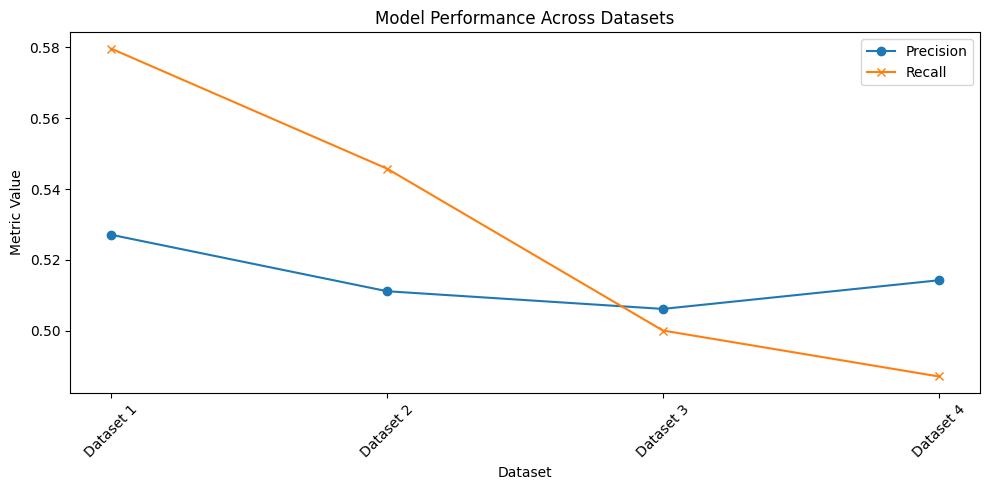

In [14]:
import matplotlib.pyplot as plt


precisions = []
recalls = []

for file_path in file_paths:
    data = np.load(file_path)
    precisions.append(np.mean(data['precision']))
    recalls.append(np.mean(data['recall']))

# Simple plot of precision and recall
plt.figure(figsize=(10, 5))
plt.plot(precisions, label='Precision', marker='o')
plt.plot(recalls, label='Recall', marker='x')
plt.title('Model Performance Across Datasets')
plt.xlabel('Dataset')
plt.ylabel('Metric Value')
plt.legend()
plt.xticks(range(len(file_paths)), labels=[f"Dataset {i+1}" for i in range(len(file_paths))], rotation=45)
plt.tight_layout()
plt.show()
